In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install transformers --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.2 MB/s eta 0:00:00


In [4]:
import json
import random
import re
import torch
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import collections
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from wordcloud import WordCloud

In [9]:
with open('/content/drive/MyDrive/11-777-MMML/layer1.json', 'r') as file:
    layer1_dic = json.load(file)

In [7]:
len(layer1_dic)

1029720

In [9]:
layer1_dic[0]

{'ingredients': [{'text': '6 ounces penne'},
  {'text': '2 cups Beechers Flagship Cheese Sauce (recipe follows)'},
  {'text': '1 ounce Cheddar, grated (1/4 cup)'},
  {'text': '1 ounce Gruyere cheese, grated (1/4 cup)'},
  {'text': '1/4 to 1/2 teaspoon chipotle chili powder (see Note)'},
  {'text': '1/4 cup (1/2 stick) unsalted butter'},
  {'text': '1/3 cup all-purpose flour'},
  {'text': '3 cups milk'},
  {'text': '14 ounces semihard cheese (page 23), grated (about 3 1/2 cups)'},
  {'text': '2 ounces semisoft cheese (page 23), grated (1/2 cup)'},
  {'text': '1/2 teaspoon kosher salt'},
  {'text': '1/4 to 1/2 teaspoon chipotle chili powder'},
  {'text': '1/8 teaspoon garlic powder'},
  {'text': '(makes about 4 cups)'}],
 'url': 'http://www.epicurious.com/recipes/food/views/-world-s-best-mac-and-cheese-387747',
 'partition': 'train',
 'title': 'Worlds Best Mac and Cheese',
 'id': '000018c8a5',
 'instructions': [{'text': 'Preheat the oven to 350 F. Butter or oil an 8-inch baking dish.'},


In [10]:
n = 3000

sample_recipe = random.sample(layer1_dic, n)

In [27]:
with open("/content/drive/MyDrive/11-777-MMML/recipe_3k.json", "w+") as f:
    json.dump(sample_recipe, f)

In [11]:
len(sample_recipe)

3000

In [16]:
sample_recipe[0]

{'ingredients': [{'text': '1 head cabbage'},
  {'text': '3 Tbsp. Sugar'},
  {'text': '4 Tbsp. Apple Cider Vinegar'},
  {'text': '1 Tbsp. Mustard'},
  {'text': '1/2 c. Mayonaise'},
  {'text': '1 c. Ketchup'},
  {'text': '1/3 c. Hienz 57'},
  {'text': '1 dsh Texas Pete'}],
 'url': 'http://cookeatshare.com/recipes/bbq-slaw-80746',
 'partition': 'val',
 'title': 'Bbq Slaw Recipe',
 'id': '15ae824fc5',
 'instructions': [{'text': "I'll let you know how it comes out."}]}

In [12]:
ingredients = []
for i in range(len(sample_recipe)):
    tmp = sample_recipe[i]['ingredients']
    tmp_ingd = ""
    for i in range(len(tmp)):
        tmp_ingd = tmp_ingd + " " + tmp[i]['text']
    ingredients.append(tmp_ingd)

In [14]:
ingredients[-1]

' 2 tbsp shortening 1 tsp soy sauce 1 tsp mustard 3/4 cup maple syrup 1 tbsp vinegar 1 tsp cornstarch 1 packages hot dogs 1 packages hamburger buns'

In [13]:
instructions = []
for i in range(len(sample_recipe)):
    tmp = sample_recipe[i]['instructions']
    tmp_inst = ""
    for i in range(len(tmp)):
        tmp_inst = tmp_inst + " " + tmp[i]['text']
    instructions.append(tmp_inst)

In [15]:
instructions[1]

' Brown ground beef with onion drain. Add other ingredients. Simmer add more seasoning to taste. This can be a little dry. This is not Health Food! I have added a little cooking oil to the Mix. Add salt and pepper. Add ground beef to your favorite Taco shells. Top with cheese, sour cream, lettuce, tomato, etc. Enjoy!'

In [16]:
def filter_only_words(s):
    # Find all words without numbers
    words = re.findall(r'\b[^\d\W]+\b', s)
    # Join words with spaces and return
    return ' '.join(words)
ingred_words = []
for tmp in ingredients:
    ingred_words.append(filter_only_words(tmp))

In [17]:
# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [40]:
encoded_ingred = []
for ingred in ingred_words:
    encoded_input = tokenizer(ingred, return_tensors='pt', padding=True, truncation=True)['input_ids']
    encoded_ingred.append(encoded_input)

In [18]:
def embed_text(text):
    # Tokenize input and obtain outputs
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        output = model(**encoded_input)

    # Take the mean of token embeddings
    embeddings = output.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

In [19]:
ingred_emb = []
for ingred in tqdm(ingred_words):
    emb = embed_text(ingred)
    ingred_emb.append(emb.reshape(1,-1))

100%|██████████| 3000/3000 [04:18<00:00, 11.61it/s]


In [24]:
ingred_matrix = np.vstack(ingred_emb)

In [25]:
ingred_matrix.shape

(3000, 768)

In [30]:
pca = PCA(n_components=2)

# Fit PCA to your data
ingred_pca = pca.fit_transform(ingred_matrix)

In [32]:
ingred_pca.shape

(3000, 2)

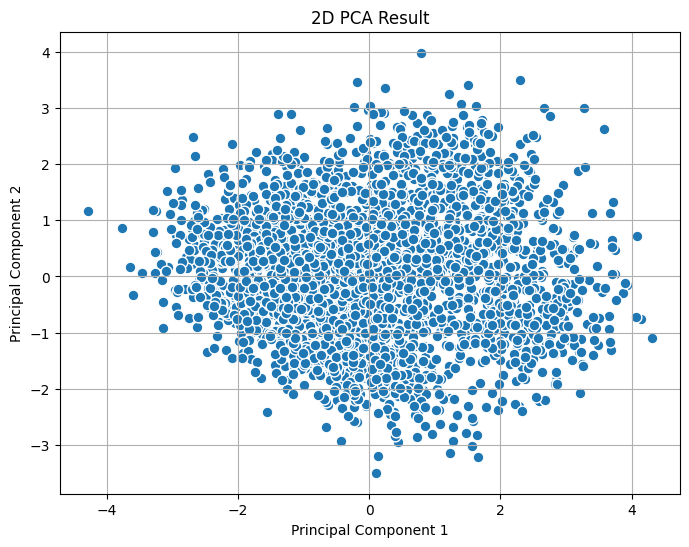

In [33]:
# Plotting the first two principal components
plt.figure(figsize=(8,6))
plt.scatter(ingred_pca[:, 0], ingred_pca[:, 1], edgecolors='w', s=60)
plt.grid(True)
plt.title("2D PCA Result")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [34]:
kmeans = KMeans(n_clusters=5)  # assuming you want to identify 2 clusters
kmeans_clusters = kmeans.fit_predict(ingred_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


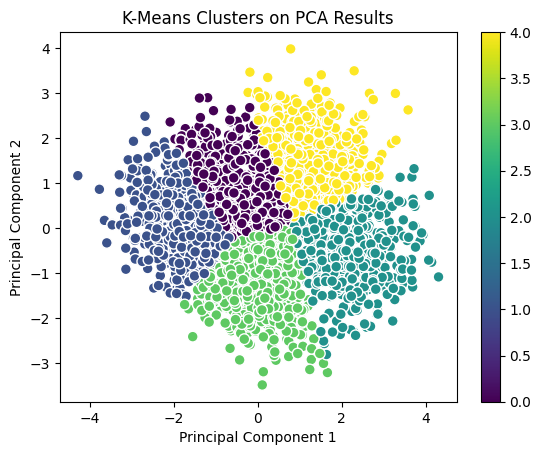

In [35]:
plt.scatter(ingred_pca[:, 0], ingred_pca[:, 1], c=kmeans_clusters, edgecolors='w', s=60, cmap='viridis')
plt.title('K-Means Clusters on PCA Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

In [36]:
cluster_indices_kmeans = {}
for cluster_number in range(kmeans.n_clusters):
    cluster_indices_kmeans[cluster_number] = np.where(kmeans_clusters == cluster_number)[0]

In [55]:
title = collections.defaultdict(list)
for i in range(5):
    for idx in cluster_indices_kmeans[i]:
        title[i].append(sample_recipe[idx]['title'])

In [61]:
with open("/content/drive/MyDrive/11-777-MMML/title_3k_kmeans_5.json", "w+") as f:
    json.dump(title, f)

In [59]:
title[0][:5]

['Sesame Green Beans',
 'Nutella Brownies Recipe',
 'Chicken Enchilada Dip',
 'Golden Parmesan Potatoes',
 'Autumn Crumble']

In [60]:
title[1][:5]

['Kale Chips',
 'Taco Filling (Ground Beef)',
 'Swiss Chard Lasagna',
 'Herb Wreath',
 "Nanny's Chicken Casserole"]

In [63]:
gmm = GaussianMixture(n_components=5)  
gmm_clusters = gmm.fit_predict(ingred_pca)

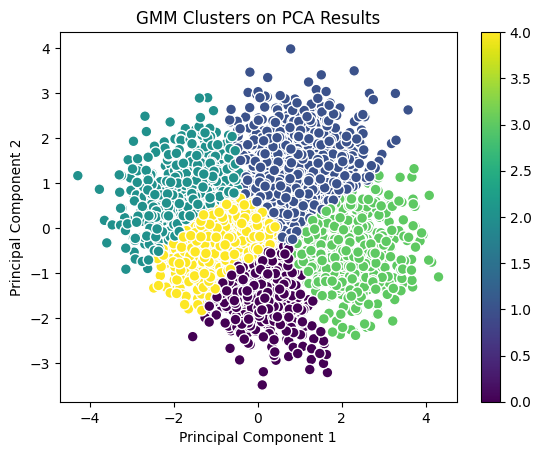

In [65]:
plt.scatter(ingred_pca[:, 0], ingred_pca[:, 1], c=gmm_clusters, edgecolors='w', s=60, cmap='viridis')
plt.title('GMM Clusters on PCA Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

In [66]:
cluster_indices_gmm = {}
for cluster_number in range(gmm.n_components):
    cluster_indices_gmm[cluster_number] = np.where(gmm_clusters == cluster_number)[0]

In [67]:
title_gmm = collections.defaultdict(list)
for i in range(5):
    for idx in cluster_indices_gmm[i]:
        title_gmm[i].append(sample_recipe[idx]['title'])

In [69]:
with open("/content/drive/MyDrive/11-777-MMML/title_3k_gmm_5.json", "w+") as f:
    json.dump(title_gmm, f)

In [ ]:
title_gmm = collections.defaultdict(list)
for i in range(5):
    for idx in cluster_indices_gmm[i]:
        title_gmm[i].append(sample_recipe[idx]['title'])

In [71]:
ingred_words[0]

'cups kale ribs and stems removed coarsely chopped tablespoon Land O Lakes Butter melted Salt if desired'

In [72]:
ingred_words_gmm = collections.defaultdict(list)
for i in range(5):
    for idx in cluster_indices_gmm[i]:
        ingred_words_gmm[i].append(ingred_words[idx])

In [74]:
with open("/content/drive/MyDrive/11-777-MMML/ingred_words_3k_gmm_5.json", "w+") as f:
    json.dump(ingred_words_gmm, f)

In [6]:
with open("/content/drive/MyDrive/11-777-MMML/ingred_words_3k_gmm_5.json", "r") as f:
    sample_ingred_words = json.load(f)
with open("/content/drive/MyDrive/11-777-MMML/title_3k_gmm_5.json", "r") as f:
    sample_titles = json.load(f)

In [9]:
def create_wordcloud(text):
    wordcloud = WordCloud(width = 400, height = 400,
                          background_color ='white',
                          stopwords = set(['and', 'with', 'II', 'for', 'of']),
                          min_font_size = 10).generate(text)
    return wordcloud

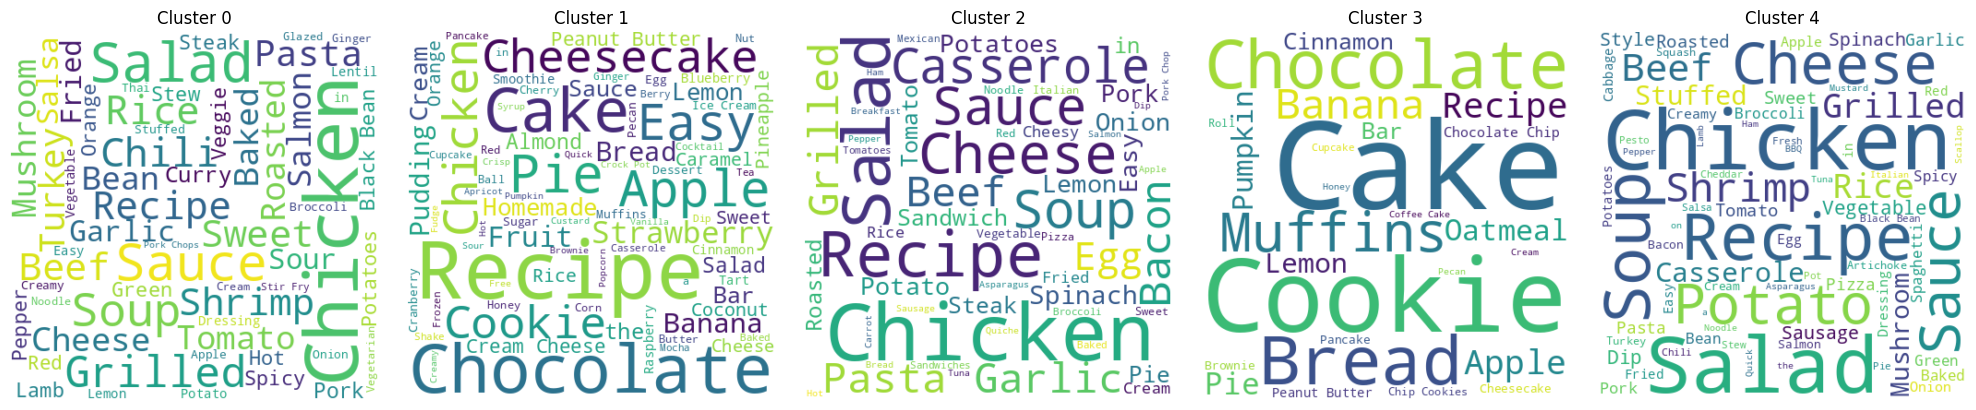

In [7]:
# Create a combined image of word clouds for all clusters
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx, (cluster, titles) in enumerate(sample_titles.items()):
    wordcloud = create_wordcloud(' '.join(titles))
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f"Cluster {cluster}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

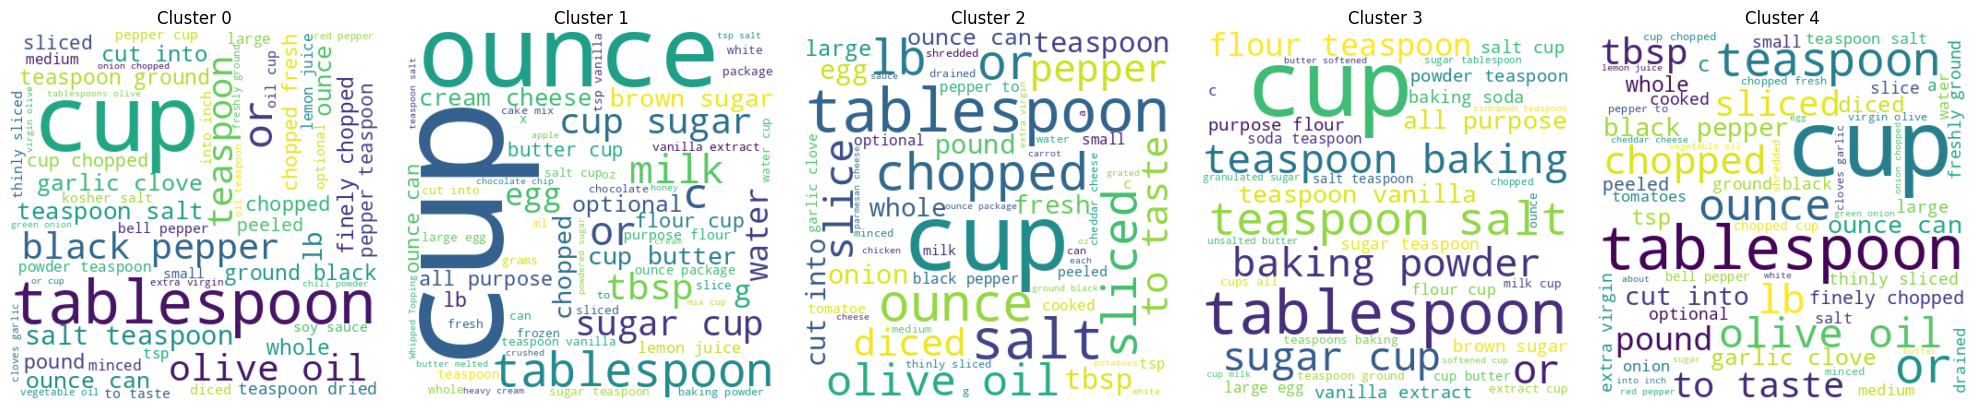

In [8]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx, (cluster, ingredients) in enumerate(sample_ingred_words.items()):
    wordcloud = create_wordcloud(' '.join(ingredients))
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f"Cluster {cluster}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()